In [1]:
import sys
import os
import glob
import copy 
import configparser
import numpy as np
import h5py
import torch

cur_dir = ''
sys.path.append(os.path.join(cur_dir,'utils'))
from data_loader import WeaveSpectraDatasetInference
from training_utils import str2bool
from network import StarNet, build_starnet, load_model_state

from analysis_fns import (plot_progress, plot_val_MAEs, predict_labels, 
                          predict_ensemble, plot_resid, plot_resid_boxplot,
                           plot_one_to_one, plot_wave_sigma)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

model_name = 'starnet_ss_1'

# Directories
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
data_dir = os.path.join(cur_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
    
# TRAINING PARAMETERS
source_data_file = os.path.join(data_dir, config['DATA']['source_data_file'])
target_data_file = os.path.join(data_dir, config['DATA']['target_data_file'])
wave_grid_file = os.path.join(data_dir, config['DATA']['wave_grid_file'])
multimodal_keys = eval(config['DATA']['multimodal_keys'])
unimodal_keys = eval(config['DATA']['unimodal_keys'])
continuum_normalize = str2bool(config['DATA']['continuum_normalize'])
divide_by_median = str2bool(config['DATA']['divide_by_median'])
random_chunk = str2bool(config['DATA']['random_chunk'])
overlap = float(config['DATA']['overlap'])

# Calculate multimodal values from source training set
with h5py.File(source_data_file, "r") as f:
    mutlimodal_vals = []
    for k in multimodal_keys:
        vals = np.unique(f[k + ' train'][:]).astype(np.float32)
        mutlimodal_vals.append(torch.from_numpy(vals).to(device))

# Build network
model = build_starnet(config, device, model_name, mutlimodal_vals)

# Load model state from previous training
model_filename =  os.path.join(model_dir, model_name+'.pth.tar')
model, losses, cur_iter = load_model_state(model, 
                                           model_filename)

load_second_chunk = model.use_split_convs
# Create dataset for loading spectra
source_train_dataset = WeaveSpectraDatasetInference(source_data_file, 
                                           dataset='train', 
                                           wave_grid_file=wave_grid_file, 
                                           multimodal_keys=multimodal_keys,
                                           unimodal_keys=unimodal_keys,
                                           continuum_normalize=continuum_normalize,
                                           divide_by_median=divide_by_median,
                                           num_fluxes=model.num_fluxes, 
                                           tasks=model.tasks, 
                                           task_means=model.task_means.cpu().numpy(), 
                                           task_stds=model.task_stds.cpu().numpy(),
                                           median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk,
                                                  overlap=overlap)

source_val_dataset = WeaveSpectraDatasetInference(source_data_file, 
                                         dataset='val', 
                                         wave_grid_file=wave_grid_file, 
                                         multimodal_keys=multimodal_keys,
                                           unimodal_keys=unimodal_keys,
                                         continuum_normalize=continuum_normalize,
                                           divide_by_median=divide_by_median,
                                         num_fluxes=model.num_fluxes, 
                                         tasks=model.tasks, 
                                         task_means=model.task_means.cpu().numpy(), 
                                         task_stds=model.task_stds.cpu().numpy(),
                                         median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk,
                                                  overlap=overlap)

target_train_dataset = WeaveSpectraDatasetInference(target_data_file, 
                                           dataset='train', 
                                           wave_grid_file=wave_grid_file, 
                                           multimodal_keys=multimodal_keys,
                                           unimodal_keys=unimodal_keys,
                                           continuum_normalize=continuum_normalize,
                                           divide_by_median=divide_by_median, 
                                           num_fluxes=model.num_fluxes,
                                           tasks=model.tasks, 
                                           task_means=model.task_means.cpu().numpy(), 
                                           task_stds=model.task_stds.cpu().numpy(),
                                           median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk,
                                                  overlap=overlap)

target_val_dataset = WeaveSpectraDatasetInference(target_data_file, 
                                         dataset='val', 
                                         wave_grid_file=wave_grid_file, 
                                         multimodal_keys=multimodal_keys,
                                           unimodal_keys=unimodal_keys,
                                         continuum_normalize=continuum_normalize,
                                           divide_by_median=divide_by_median,
                                         num_fluxes=model.num_fluxes,
                                         tasks=model.tasks, 
                                         task_means=model.task_means.cpu().numpy(), 
                                         task_stds=model.task_stds.cpu().numpy(),
                                         median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk,
                                                  overlap=overlap)

print('The source training set consists of %i spectra.' % (len(source_train_dataset)))
print('The source validation set consists of %i spectra.' % (len(source_val_dataset)))

print('The target training set consists of %i spectra.' % (len(target_train_dataset)))
print('The target validation set consists of %i spectra.' % (len(target_val_dataset)))

Using Torch version: 1.13.1+cu117
Using a cpu device

Creating model: starnet_ss_1

Configuration:
  DATA
    source_data_file: ambre.h5
    target_data_file: golden_sample.h5
    wave_grid_file: weave_hr_wavegrid_arms.npy
    multimodal_keys: ['teff', 'feh', 'logg', 'alpha']
    unimodal_keys: ['vrad']
    continuum_normalize: True
    divide_by_median: False
    add_noise_to_source: True
    random_chunk: True
    overlap: 0.5
  TRAINING
    batchsize: 8
    lr: 0.001
    weight_decay: 0.01
    total_batch_iters: 1000000
    source_mm_weights: [5.0, 5.0, 5.0, 5.0]
    source_um_weights: [0.1]
    target_feature_weight: 0.01
    source_feature_weight: 0.01
    source_task_weights: [0.1, 0.05, 0.05, 0.1]
    target_task_weights: [0.1, 0.05, 0.05, 0.1]
  ARCHITECTURE
    spectrum_size: 43480
    num_fluxes: 6000
    encoder_dim: 18
    conv_filts_sh: [128, 128, 128, 128]
    conv_strides_sh: [4, 2, 2, 2]
    filter_lengths_sh: [15, 15, 7, 7]
    conv_filts_sp: [32]
    conv_strides_sp: 

### **Display training progress**

starnet_ss_1


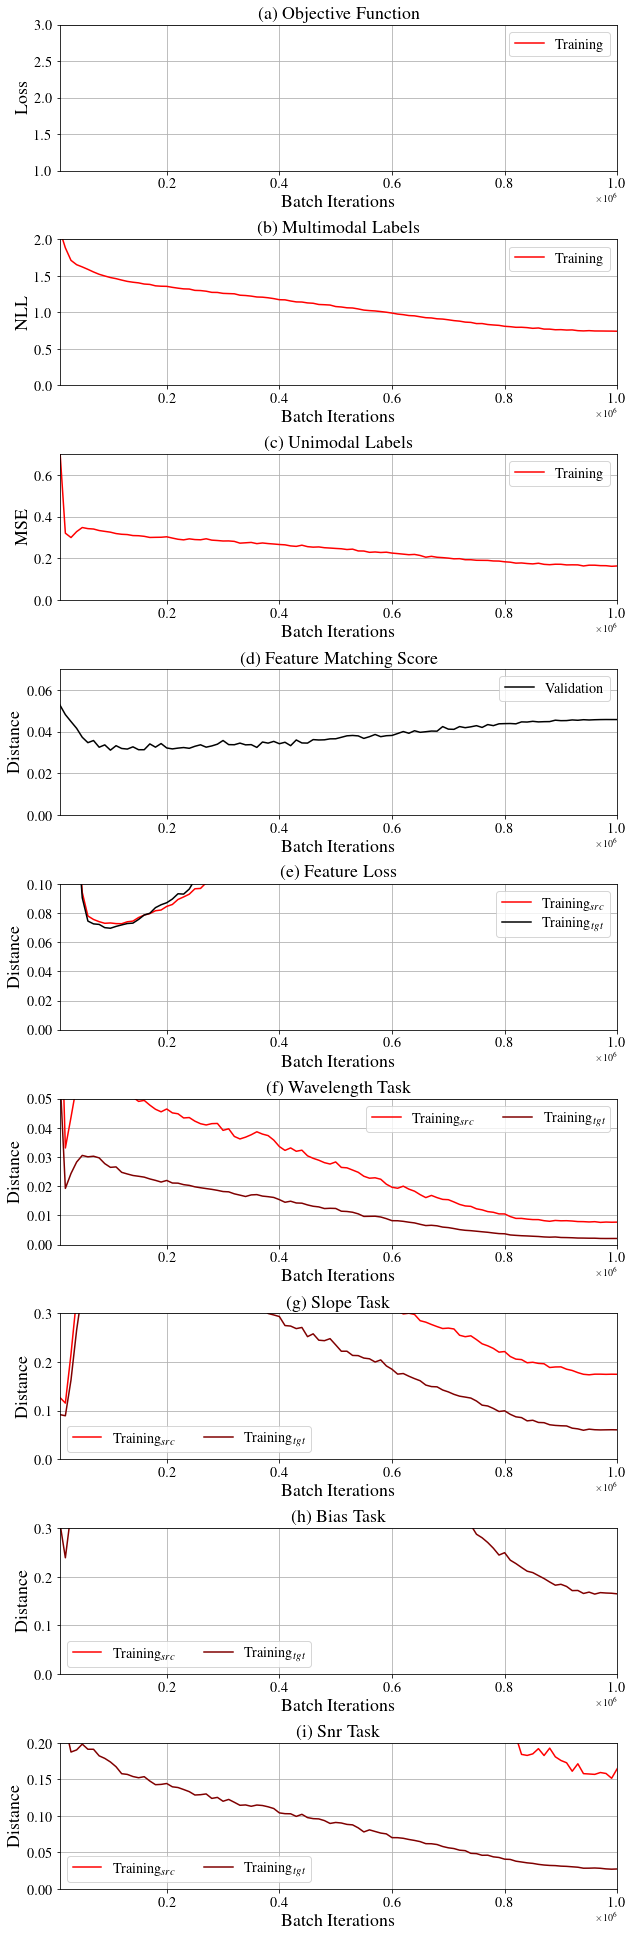

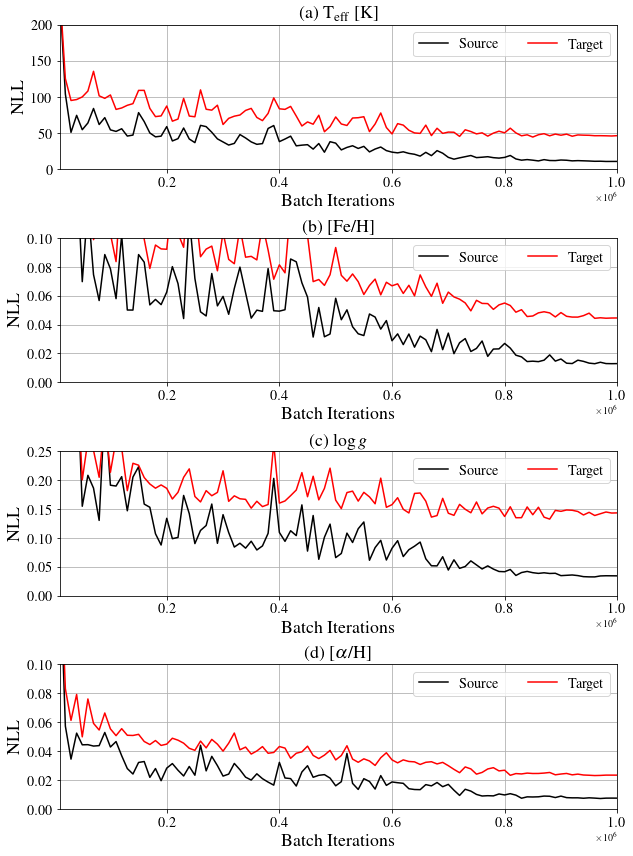

In [2]:
print(model_name)
plot_progress(losses, model.tasks, 
              y_lims=[(1,3),(0.,2),(0.0,0.7),(0,0.07),(0,0.1),(0,0.05),(0,0.3),(0,0.3),(0,0.2)])

plot_val_MAEs(losses, multimodal_keys, y_lims=[(0.,200.), (0.,0.1), (0.,0.25), (0.,.1)])

### **Predict on Source Dataset**

Predicting on 10452 spectra...
starnet_ss_1


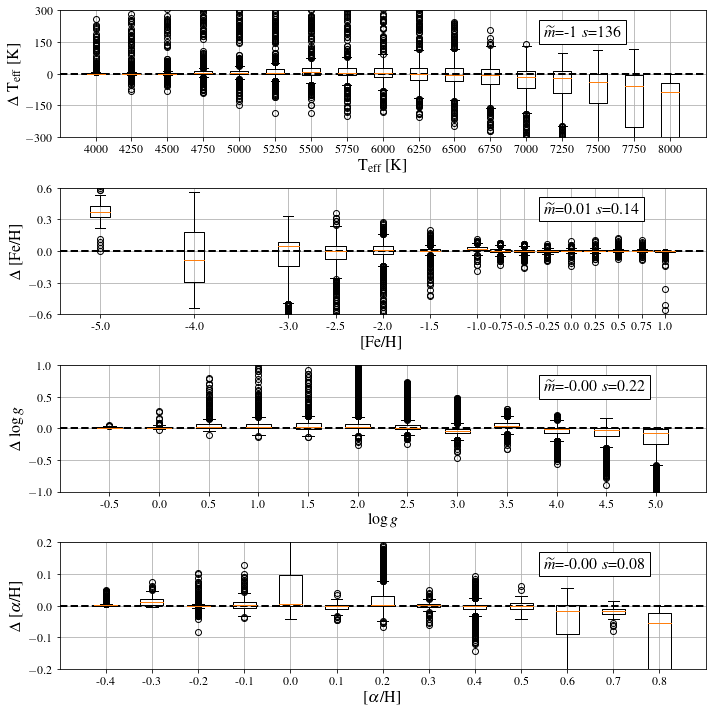

In [3]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, source_train_dataset)

print(model_name)
#plot_resid(multimodal_keys+unimodal_keys, tgt_stellar_labels, pred_stellar_labels,
#          y_lims = [300, 0.5, 0.7, 0.25, 15])

plot_resid_boxplot(multimodal_keys, tgt_stellar_labels[:,:-1], pred_stellar_labels[:,:-1],
                   y_lims=[300, 0.6, 1, 0.2])

#plot_one_to_one(multimodal_keys+unimodal_keys, tgt_stellar_labels, pred_stellar_labels)

### **Predict on Target Dataset**

Predicting on 3559 spectra...
starnet_ss_1


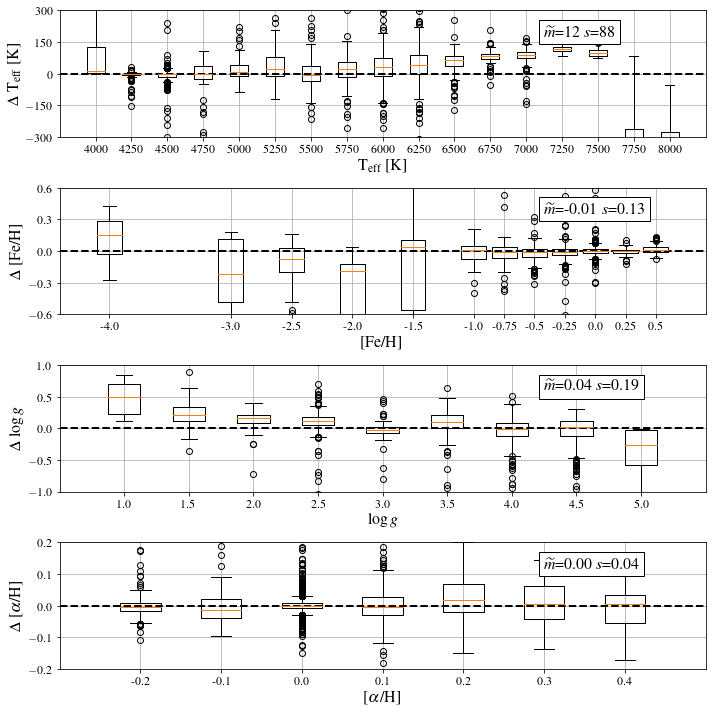

In [4]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_train_dataset)

print(model_name)
#plot_resid(multimodal_keys+unimodal_keys, tgt_stellar_labels, pred_stellar_labels,
#          y_lims = [300, 0.5, 0.7, 0.25, 15])

plot_resid_boxplot(multimodal_keys, tgt_stellar_labels[:,:-1], pred_stellar_labels[:,:-1],
                   y_lims=[300, 0.6, 1, 0.2])

#plot_one_to_one(multimodal_keys+unimodal_keys, tgt_stellar_labels, pred_stellar_labels)